In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
df_salario = pd.read_csv('./datasets/dataset_salario.csv')

In [42]:
df_salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [43]:
df_salario_eda = df_salario.copy()
df_salario_bucketing = df_salario.copy()

## Analise Exploratoria

In [44]:
df_salario_eda.head()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20


In [45]:
df_salario_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [46]:
# Medidas Estatisticas

df_salario_eda.describe()


,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


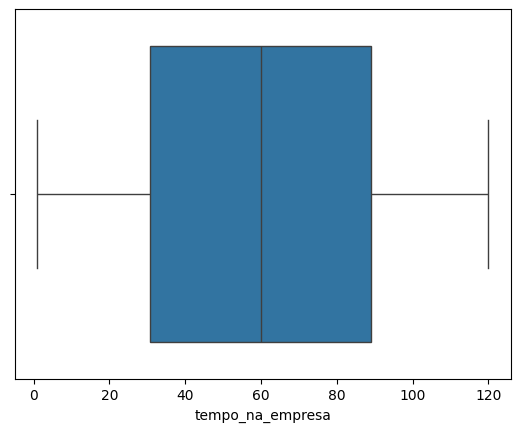

In [47]:
# Detectar outliers

sns.boxplot(data=df_salario_eda, x='tempo_na_empresa')
plt.show()

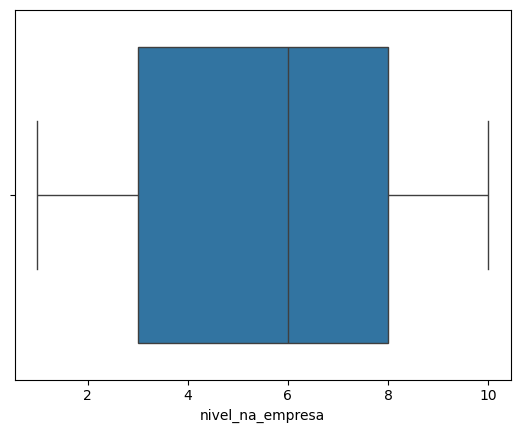

In [48]:
sns.boxplot(data=df_salario_eda, x='nivel_na_empresa')
plt.show()

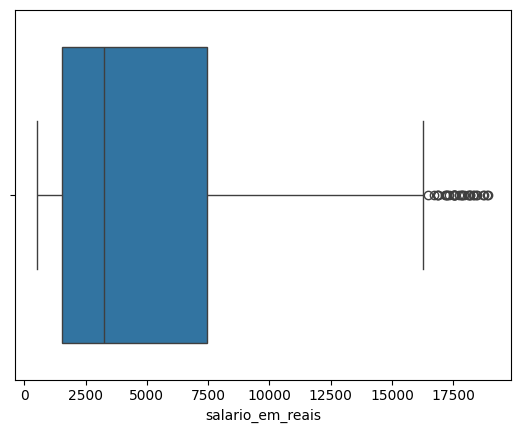

In [49]:
sns.boxplot(data=df_salario_eda, x='salario_em_reais')
plt.show()

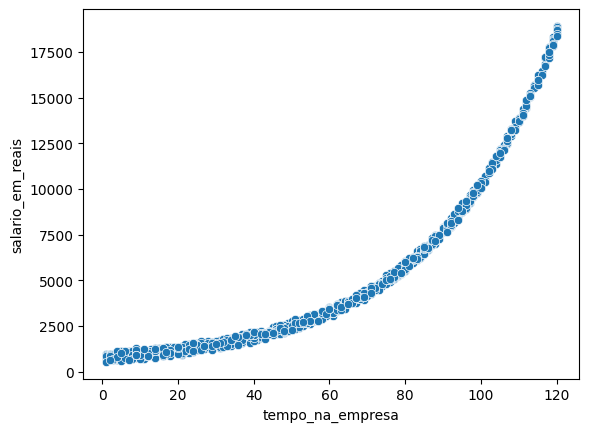

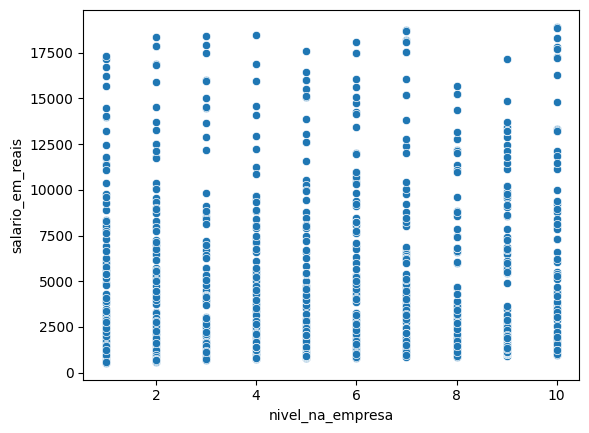

<Axes: xlabel='nivel_na_empresa', ylabel='tempo_na_empresa'>

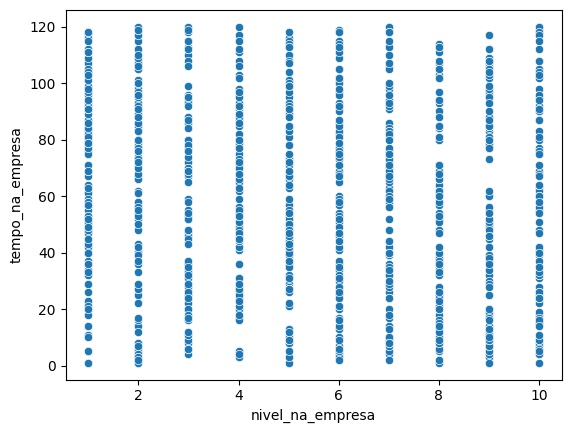

In [50]:
# Análise Gráfica
# using scatterplot

sns.scatterplot(data=df_salario_eda, x='tempo_na_empresa', y='salario_em_reais')
plt.show()
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='salario_em_reais')
plt.show()
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='tempo_na_empresa')

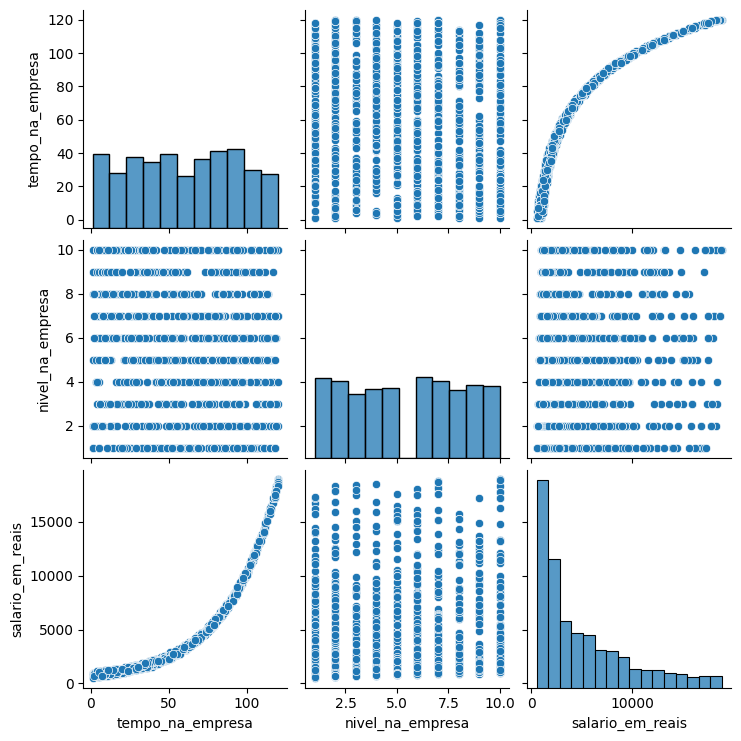

In [51]:
sns.pairplot(df_salario_eda)

<Axes: >

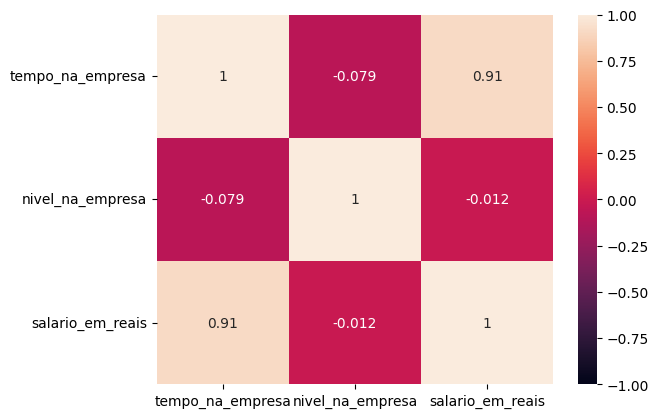

In [52]:
# Mapa de Calor

sns.heatmap(df_salario_eda.corr(), vmin=-1, vmax=1, annot=True)

<Axes: >

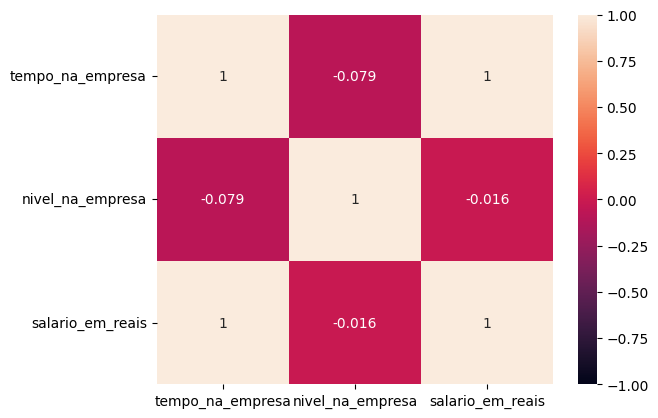

In [53]:
# Mapa de Calor

sns.heatmap(df_salario_eda.corr('spearman'), vmin=-1, vmax=1, annot=True)

<Axes: >

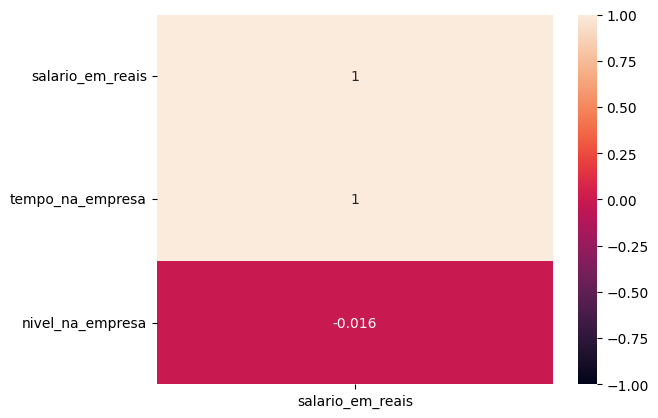

In [54]:
# Mapa de Calor

sns.heatmap(df_salario_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), vmin=-1, vmax=1, annot=True)

In [55]:
# Bucketing de "tempo_de_empresa"

bins_tempo_empresa = [0,10,20,30,40,50,60,70,80,90,100,110,120]
# labels for "tempo_de_casa"

labels_tempo_empresa = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110','110-120']
df_salario_bucketing['tempo_na_empresa'] = pd.cut(df_salario_bucketing['tempo_na_empresa'], bins=bins_tempo_empresa, labels=labels_tempo_empresa)
df_salario_bucketing.head()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,40-50,1,2288.13
1,40-50,4,2389.84
2,30-40,10,2158.73
3,50-60,1,2341.06
4,60-70,7,3584.20


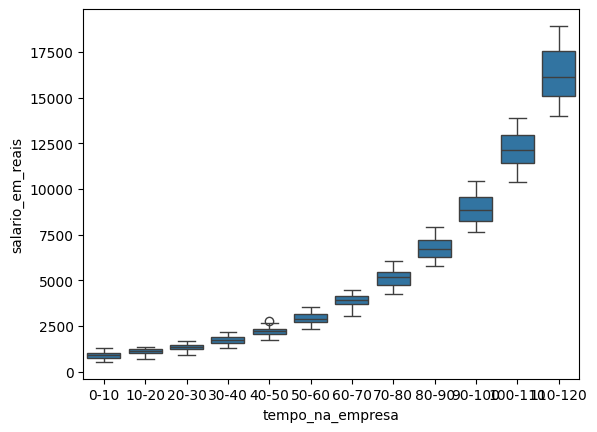

In [56]:
# Boxplot

sns.boxplot(data=df_salario_bucketing, x='tempo_na_empresa', y='salario_em_reais')
plt.show()

## MODELO LINEAR

## Preparação para Treinamento
- antes vamos verificar se o modelo linear funciona
- vamos utilizar k-fold

In [57]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error

import numpy as np

In [58]:
# Criar dataset de Treino e Teste

X = df_salario.drop(columns='salario_em_reais', axis=1)
y = df_salario['salario_em_reais']

In [59]:
# Split usando KFold com 5 splits

kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [60]:
# Treinamento do Modelo usando pipeline

colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

# Transformer para padronizar Colunas Numericas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, colunas_numericas)
])

# Pipeline

modelo = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [61]:
# Treinar o modelo usando os splits do 4 fold
# armazenar as metricas RMSE de treino e teste
# com isso pode verificar um overfiting
rmse_fold_train = []
rmse_fold_teste = []

# armazenar R-score de teste
r2score_fold_test = []

# armazenar residuos
residuos = []

# armazenar as predicoes
y_pred = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treinar o modelo
    modelo.fit(X_train, y_train)

    # Prever os valores de treino e teste
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    # Armazenar as predicoes
    y_pred.append(y_pred_test)

    # Armazenar o RMSE de treino e teste
    rmse_fold_train.append(root_mean_squared_error(y_train, y_pred_train))
    rmse_fold_teste.append(root_mean_squared_error(y_test, y_pred_test))

    # Armazenar o R-score de teste
    r2score_fold_test.append(r2_score(y_test, y_pred_test))

    # Armazenar os residuos
    residuos.append(np.array(y_test - y_pred_test))

# Media do RMSE teste e treino
rmse_fold_train_mean = np.mean(rmse_fold_train)
rmse_fold_teste_mean = np.mean(rmse_fold_teste)

# Diferenca percentual
rmse_diferenca_percentual = (rmse_fold_teste_mean - rmse_fold_train_mean) / rmse_fold_train_mean * 100

# Media de R2Score de teste
r2score_fold_test_mean = np.mean(r2score_fold_test)

# Residuos
residuos = np.array(residuos).reshape(-1)

# Predicoes
y_pred = np.array(y_pred).reshape(-1)


### Analise das Metricas

In [62]:
# Metricas

print(f'RMSE de Treino: {rmse_fold_train_mean}')
print(f'RMSE de Teste: {rmse_fold_teste_mean}')
print(f'Diferença Percentual: {rmse_diferenca_percentual}')
print(f'R2Score de Teste: {r2score_fold_test_mean}')

RMSE de Treino: 1882.8318426651392
RMSE de Teste: 1886.4504221336076
Diferença Percentual: 0.19218813844503052
R2Score de Teste: 0.8261178870584761


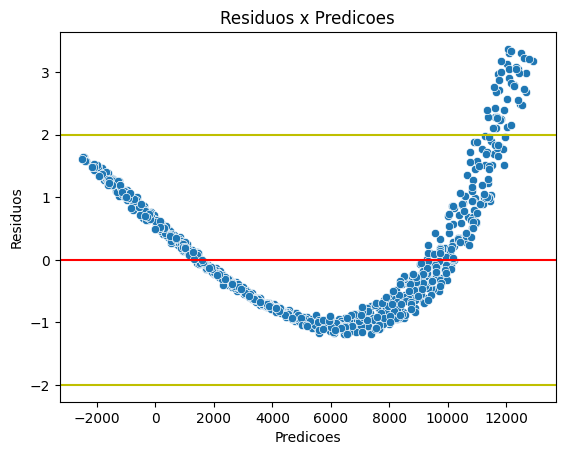

In [63]:
# Analise de Residuos

from scipy.stats import zscore

residuous_std = zscore(residuos)

# Verificar a lineraridade dos residuos: valores entre -2 e +2
# Verificar a homocedasticidade: valores em torno da reta sem senhuma tendencia ou formato

sns.scatterplot(x=y_pred, y=residuous_std)

plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=2, color='y', linestyle='-')
plt.axhline(y=-2, color='y', linestyle='-')

plt.xlabel('Predicoes')
plt.ylabel('Residuos')
plt.title('Residuos x Predicoes')

plt.show()

- nao ha linearidade nem homocesdasticidade

Text(0, 0.5, 'Residuos na escala padrao')

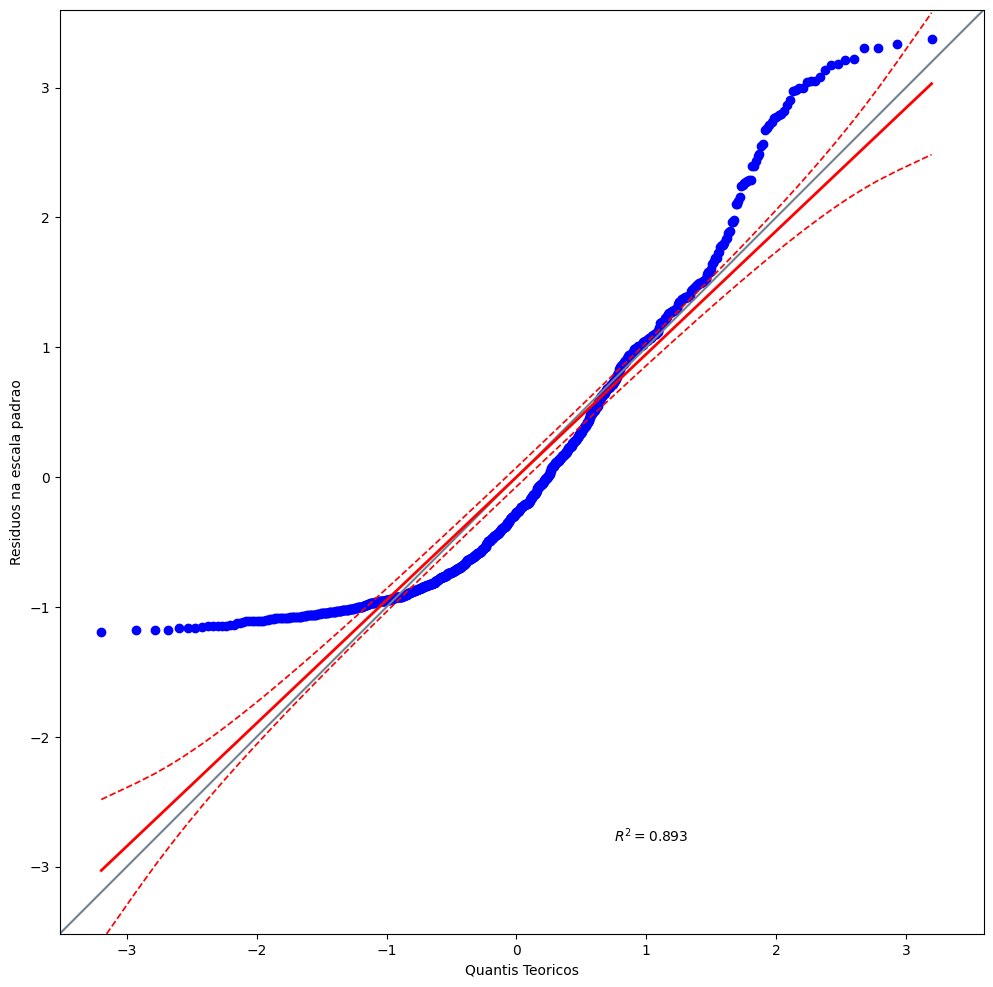

In [64]:
# Checar se os residuos seguem uma distribuicao normal
# QQ Plot

import pingouin as pg

plt.figure(figsize=(20,12))
pg.qqplot(residuous_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teoricos')
plt.ylabel('Residuos na escala padrao')

- nao segue distribuicao normal

In [65]:
# Testes estatisticos de residuos

# Teste de Normalidade de Shapiro-Wilk

from scipy.stats import shapiro
stat, p = shapiro(residuous_std)

stat_shapiro, p_value_shapiro = shapiro(residuos)

print(f'Estatistica de Shapiro-Wilk: {stat_shapiro}')
print(f'P-value de Shapiro-Wilk: {p_value_shapiro}')

if p_value_shapiro < 0.05:
    print('Hipotese nula rejeitada -> nao segue distribuicao normal')


Estatistica de Shapiro-Wilk: 0.8919692179652284
P-value de Shapiro-Wilk: 7.013497918014399e-26
Hipotese nula rejeitada -> nao segue distribuicao normal


In [66]:
# Teste de Normalidade de Kolmogorov-Smirnov
from scipy.stats import kstest

stat_kstest, p_value_kstest = kstest(residuos, 'norm')

print(f'Estatistica de Kolmogorov-Smirnov: {stat_kstest}')
print(f'P-value de Kolmogorov-Smirnov: {p_value_kstest}')

if p_value_kstest < 0.05:
  print('Hipotese nula rejeitada -> nao segue distribuicao normal')

Estatistica de Kolmogorov-Smirnov: 0.5939999999999955
P-value de Kolmogorov-Smirnov: 0.0
Hipotese nula rejeitada -> nao segue distribuicao normal


In [67]:
# Teste de Normalidade de Lilliefors

from statsmodels.stats.diagnostic import lilliefors

stat_lilliefors, p_value_lilliefors = lilliefors(residuos, dist='norm', pvalmethod='table')

print(f'Estatistica de Lilliefors: {stat_lilliefors}')
print(f'P-value de Lilliefors: {p_value_lilliefors}')

if p_value_lilliefors < 0.05:
  print('Hipotese nula rejeitada -> nao segue distribuicao normal')



Estatistica de Lilliefors: 0.11825983774680093
P-value de Lilliefors: 0.0009999999999998899
Hipotese nula rejeitada -> nao segue distribuicao normal


## MODELO POLINOMIAL

In [68]:
# Exemplo de criacao de features polinomiais

feat_poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = feat_poly.fit_transform(X)

feat_poly.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [69]:
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [70]:
# Treinamento do Modelo usando pipeline

graus_polynomial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rmse_train_means = []
rmse_test_means = []
rmse_diferenca_percentual_means = []
r2score_teste_means= []

# Split usando KFold com 5 splits

kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:
    colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

    # Transformer para padronizar Colunas Numericas
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, colunas_numericas)
    ])

    # Features Polinomiais
    feature_poly = PolynomialFeatures(degree=grau, include_bias=False)

    # Pipeline

    modelo_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', feature_poly),
        ('regressor', LinearRegression())
    ])

    # Treinar o modelo usando os splits do 4 fold
    # armazenar as metricas RMSE de treino e teste
    # com isso pode verificar um overfiting
    rmse_fold_train = []
    rmse_fold_teste = []

    # armazenar R-score de teste
    r2score_fold_test = []

    # armazenar residuos
    residuos = []

    # armazenar as predicoes
    y_pred = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treinar o modelo
        modelo_poly.fit(X_train, y_train)

        # Prever os valores de treino e teste
        y_pred_train = modelo_poly.predict(X_train)
        y_pred_test = modelo_poly.predict(X_test)

        # Armazenar as predicoes
        y_pred.append(y_pred_test)

        # Armazenar o RMSE de treino e teste
        rmse_fold_train.append(root_mean_squared_error(y_train, y_pred_train))
        rmse_fold_teste.append(root_mean_squared_error(y_test, y_pred_test))

        # Armazenar o R-score de teste
        r2score_fold_test.append(r2_score(y_test, y_pred_test))

        # Armazenar os residuos
        residuos.append(np.array(y_test - y_pred_test))

    # Media do RMSE teste e treino
    rmse_fold_train_mean = np.mean(rmse_fold_train)
    rmse_fold_teste_mean = np.mean(rmse_fold_teste)

    # Diferenca percentual
    rmse_diferenca_percentual = (rmse_fold_teste_mean - rmse_fold_train_mean) / rmse_fold_train_mean * 100

    # Media de R2Score de teste
    r2score_fold_test_mean = np.mean(r2score_fold_test)

    # Residuos
    residuos = np.array(residuos).reshape(-1)

    # Predicoes
    y_pred = np.array(y_pred).reshape(-1)

    # Armazenar valores nas listas
    rmse_train_means.append(rmse_fold_train_mean)
    rmse_test_means.append(rmse_fold_teste_mean)
    rmse_diferenca_percentual_means.append(rmse_diferenca_percentual)
    r2score_teste_means.append(r2score_fold_test_mean)

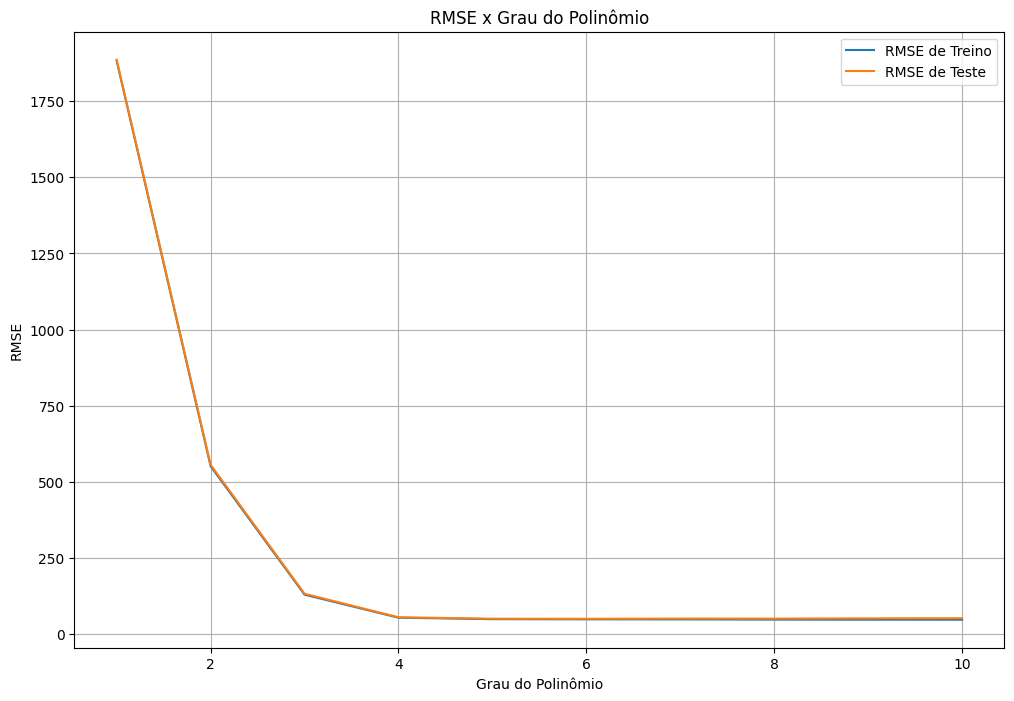

In [71]:
# Comparar RMSE de cada grau

plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, rmse_train_means, label='RMSE de Treino')
plt.plot(graus_polynomial, rmse_test_means, label='RMSE de Teste')
plt.xlabel('Grau do Polinômio')
plt.ylabel('RMSE')
plt.title("RMSE x Grau do Polinômio")
plt.legend()
plt.grid(True)

Text(0.5, 1.0, 'Diferença Percentual - RMSE x Grau do Polinômio')

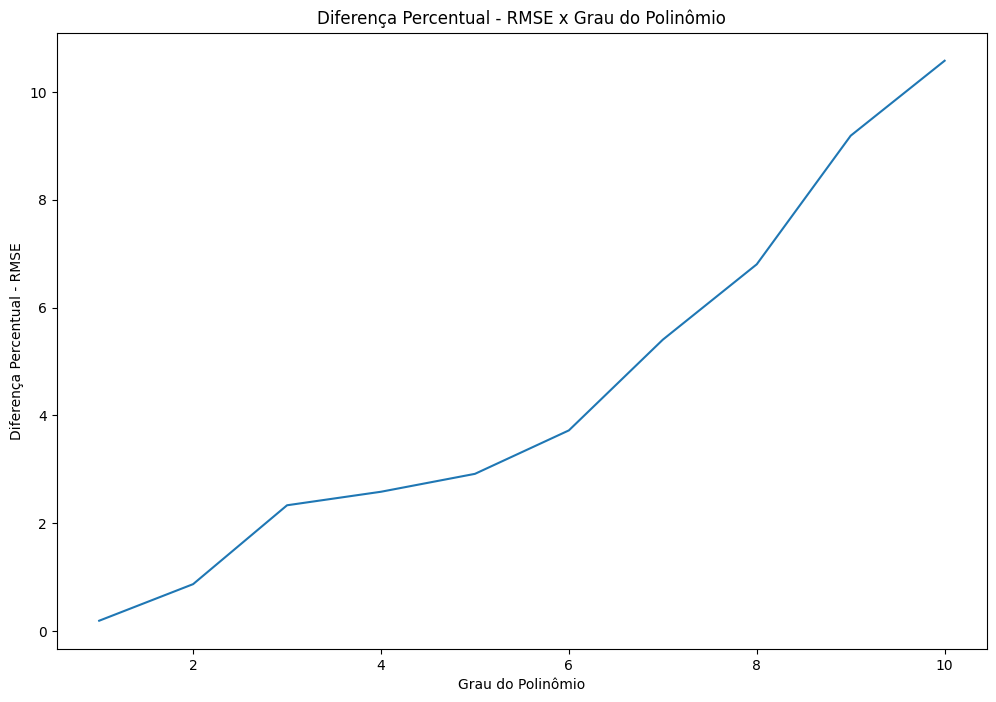

In [72]:
# Plotar diferença percentual

plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, rmse_diferenca_percentual_means)
plt.xlabel('Grau do Polinômio')
plt.ylabel('Diferença Percentual - RMSE')
plt.title("Diferença Percentual - RMSE x Grau do Polinômio")

- Ideal: polinômio de grau 4
- minimizar overfitting
- RMSE menor possível

### Treinar modelo com polinômio de grau 4

In [73]:
# Treinamento do Modelo usando pipeline

grau_polynomial = 4
    
colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

# Transformer para padronizar Colunas Numericas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, colunas_numericas)
])

# Features Polinomiais
feature_poly = PolynomialFeatures(degree=grau_polynomial, include_bias=False)

# Pipeline

modelo_poly_grau4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', feature_poly),
    ('regressor', LinearRegression())
])

# Treinar o modelo usando os splits do 4 fold
# armazenar as metricas RMSE de treino e teste
# com isso pode verificar um overfiting
rmse_fold_train = []
rmse_fold_teste = []

# armazenar R-score de teste
r2score_fold_test = []

# armazenar residuos
residuos = []

# armazenar as predicoes
y_pred = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treinar o modelo
    modelo_poly_grau4.fit(X_train, y_train)

    # Prever os valores de treino e teste
    y_pred_train = modelo_poly_grau4.predict(X_train)
    y_pred_test = modelo_poly_grau4.predict(X_test)

    # Armazenar as predicoes
    y_pred.append(y_pred_test)

    # Armazenar o RMSE de treino e teste
    rmse_fold_train.append(root_mean_squared_error(y_train, y_pred_train))
    rmse_fold_teste.append(root_mean_squared_error(y_test, y_pred_test))

    # Armazenar o R-score de teste
    r2score_fold_test.append(r2_score(y_test, y_pred_test))

    # Armazenar os residuos
    residuos.append(np.array(y_test - y_pred_test))

# Media do RMSE teste e treino
rmse_fold_train_mean = np.mean(rmse_fold_train)
rmse_fold_teste_mean = np.mean(rmse_fold_teste)

# Diferenca percentual
rmse_diferenca_percentual = (rmse_fold_teste_mean - rmse_fold_train_mean) / rmse_fold_train_mean * 100

# Media de R2Score de teste
r2score_fold_test_mean = np.mean(r2score_fold_test)

# Residuos
residuos = np.array(residuos).reshape(-1)

# Predicoes
y_pred = np.array(y_pred).reshape(-1)

# Armazenar valores nas listas
rmse_train_means.append(rmse_fold_train_mean)
rmse_test_means.append(rmse_fold_teste_mean)
rmse_diferenca_percentual_means.append(rmse_diferenca_percentual)
r2score_teste_means.append(r2score_fold_test_mean)

## Validação do Modelo

In [74]:
# Metrícas

print(f'RMSE de Treino: {rmse_fold_train_mean}')
print(f'RMSE de Teste: {rmse_fold_teste_mean}')
print(f'Diferença Percentual: {rmse_diferenca_percentual}')
print(f'R2Score de Teste: {r2score_fold_test_mean}')

RMSE de Treino: 53.32698559565159
RMSE de Teste: 54.70504352796327
Diferença Percentual: 2.5841661907551114
R2Score de Teste: 0.9998524123039415


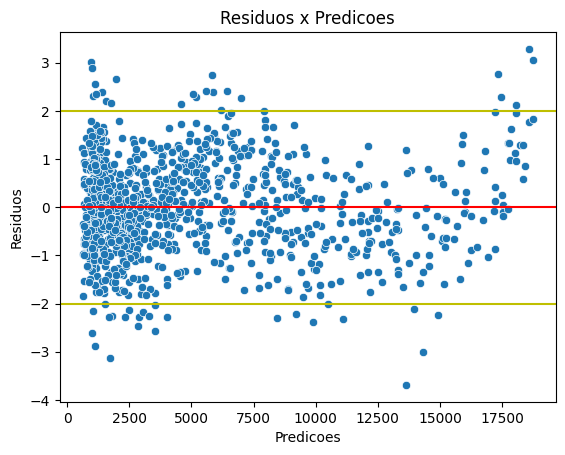

In [75]:
# Análise de Resíduos

# Analise de Residuos

from scipy.stats import zscore

residuous_std = zscore(residuos)

# Verificar a lineraridade dos residuos: valores entre -2 e +2
# Verificar a homocedasticidade: valores em torno da reta sem senhuma tendencia ou formato

sns.scatterplot(x=y_pred, y=residuous_std)

plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=2, color='y', linestyle='-')
plt.axhline(y=-2, color='y', linestyle='-')

plt.xlabel('Predicoes')
plt.ylabel('Residuos')
plt.title('Residuos x Predicoes')

plt.show()

- piorou um pouquinho a linearidade, mas melhorou MUITO homocedasticidade

Text(0, 0.5, 'Residuos na escala padrao')

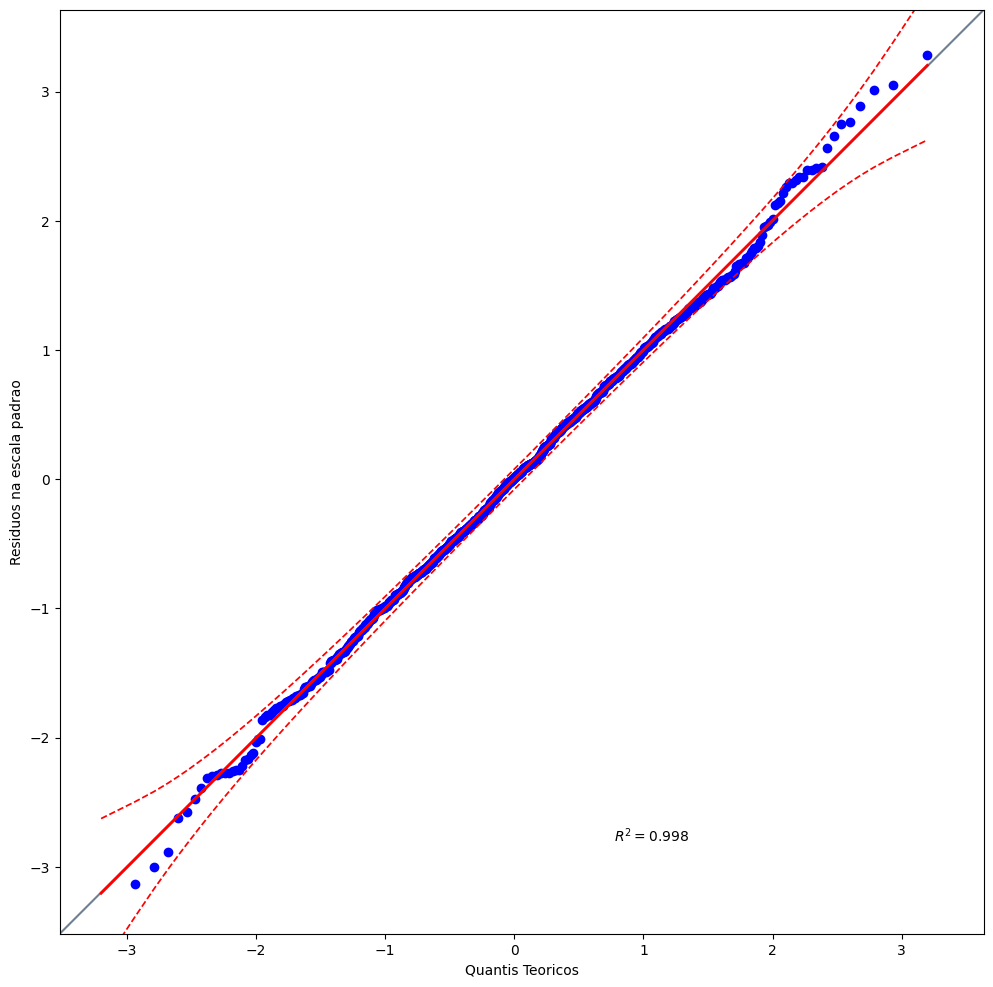

In [76]:
# Checar se os residuos seguem uma distribuicao normal
# QQ Plot

import pingouin as pg

plt.figure(figsize=(20,12))
pg.qqplot(residuous_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teoricos')
plt.ylabel('Residuos na escala padrao')

In [78]:
# Testes estatisticos de residuos

# Teste de Normalidade de Shapiro-Wilk

from scipy.stats import shapiro
stat, p = shapiro(residuous_std)

stat_shapiro, p_value_shapiro = shapiro(residuos)

print(f'Estatistica de Shapiro-Wilk: {stat_shapiro}')
print(f'P-value de Shapiro-Wilk: {p_value_shapiro}')

if p_value_shapiro < 0.05:
    print('Hipotese nula rejeitada -> nao segue distribuicao normal')
else:
    print('Hipotese nula não rejeitada -> segue distribuicao normal')



Estatistica de Shapiro-Wilk: 0.9986951372205334
P-value de Shapiro-Wilk: 0.6852797159667293
Hipotese nula não rejeitada -> segue distribuicao normal


In [80]:
# Teste de Normalidade de Kolmogorov-Smirnov
from scipy.stats import kstest

stat_kstest, p_value_kstest = kstest(residuos, 'norm')

print(f'Estatistica de Kolmogorov-Smirnov: {stat_kstest}')
print(f'P-value de Kolmogorov-Smirnov: {p_value_kstest}')

if p_value_kstest < 0.05:
  print('Hipotese nula rejeitada -> nao segue distribuicao normal')
else:
  print('Hipotese nula não rejeitada -> segue distribuicao normal')

Estatistica de Kolmogorov-Smirnov: 0.48237446499535763
P-value de Kolmogorov-Smirnov: 1.220246010522094e-214
Hipotese nula rejeitada -> nao segue distribuicao normal


In [81]:
# Teste de Normalidade de Lilliefors

from statsmodels.stats.diagnostic import lilliefors

stat_lilliefors, p_value_lilliefors = lilliefors(residuos, dist='norm', pvalmethod='table')

print(f'Estatistica de Lilliefors: {stat_lilliefors}')
print(f'P-value de Lilliefors: {p_value_lilliefors}')

if p_value_lilliefors < 0.05:
  print('Hipotese nula rejeitada -> nao segue distribuicao normal')
else:
  print('Hipotese nula não rejeitada -> segue distribuicao normal')

Estatistica de Lilliefors: 0.013637346894967206
P-value de Lilliefors: 0.9566270022048831
Hipotese nula não rejeitada -> segue distribuicao normal


### Realizar predições individuais e salvar o modelo

In [86]:
# Fazendo predições

input = { 'tempo_na_empresa': 72, 'nivel_na_empresa': 10}

y_pred = modelo_poly_grau4.predict(pd.DataFrame(input, index=[0]))

y_pred

array([4808.03154228])

In [87]:
import joblib

joblib.dump(modelo_poly_grau4,'./modelo_poly_grau4.pkl')

['./modelo_poly_grau4.pkl']